In [5]:
#*********************************
# Name: Walmart Sales Forecasting
# Date: January 2024
# Creator: Jonah Zembower
#*********************************
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

data = pd.read_csv("/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Coding Applications/Datasets/Personal Projects/Walmart/Walmart.csv") #Import Walmart CSV Dataset 

In [6]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [8]:
numericalData = data.select_dtypes(include = ['float64', 'int64']).columns
print(f"\nNumerical Features:\n{numericalData}")

categoricalData = data.select_dtypes(include = ['object']).columns
print(f"\nCategorical Features:\n{categoricalData}")


Numerical Features:
Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

Categorical Features:
Index(['Date'], dtype='object')


In [9]:
def seasonName(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"
    
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data['Month_Name'] = data['Date'].dt.month_name()
data['Season'] = data['Date'].dt.month.apply(seasonName)
data['Week'] = data['Date'].dt.isocalendar().week.astype('int32')

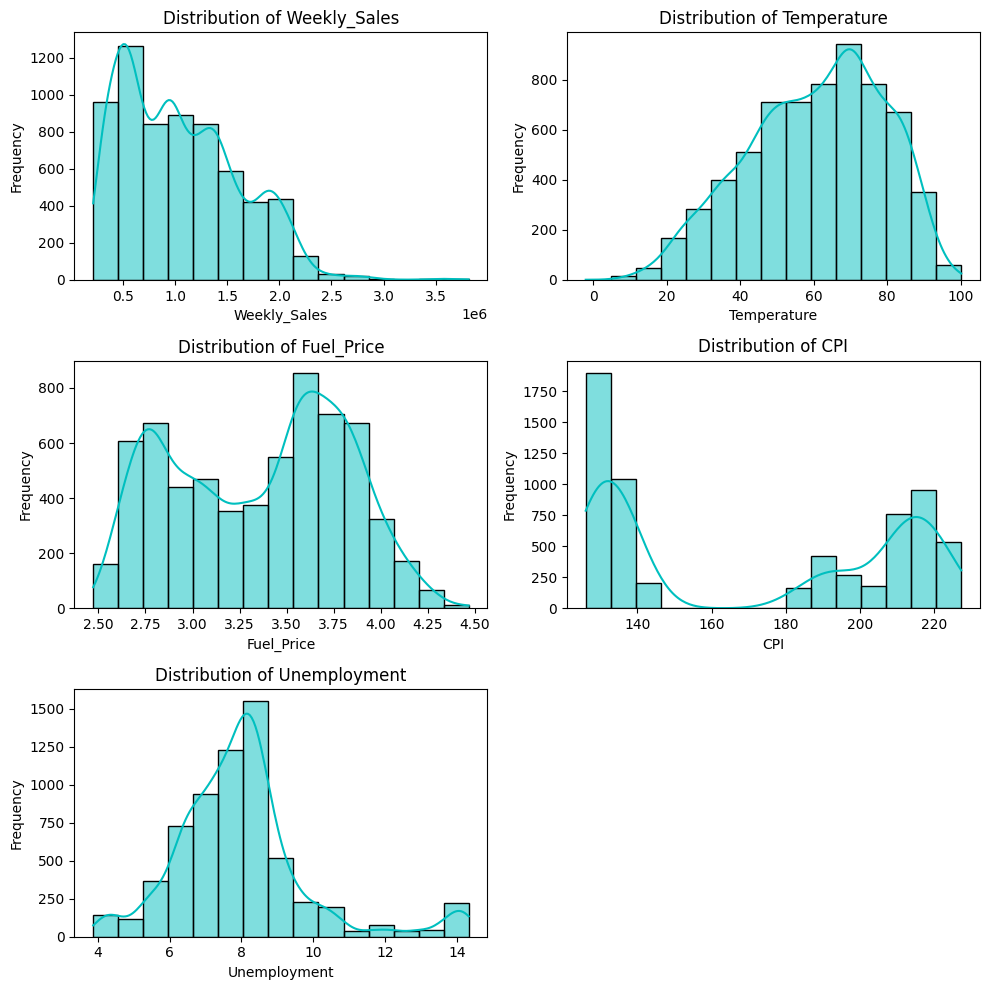

In [10]:
numericalData = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.figure(figsize = (10, 10))

for i in numericalData:
    plt.subplot(3, 2, numericalData.index(i) + 1)
    sns.histplot(data = data, x = i, kde = True, bins = 15, color = 'c')
    plt.title(f"Distribution of {i}")
    plt.xlabel(i)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

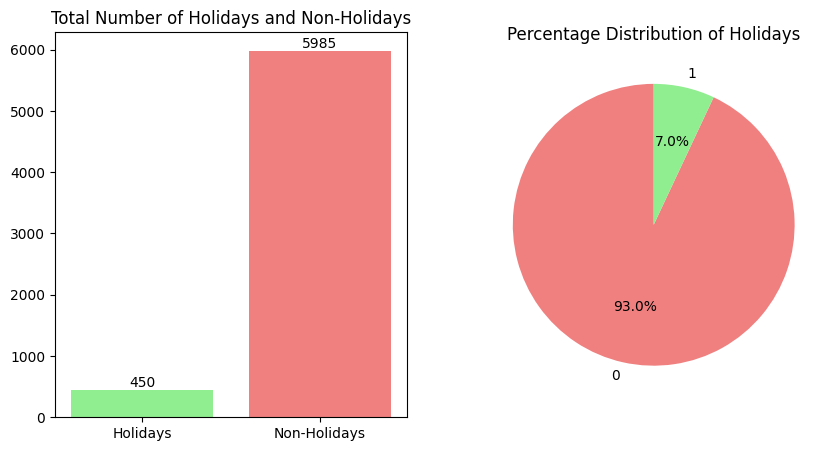

In [11]:
holidayFlagCounts = data['Holiday_Flag'].value_counts()

totalHolidays = holidayFlagCounts.get(1, 0)
totalNonHolidays = holidayFlagCounts.get(0, 0)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Holidays', 'Non-Holidays'], [totalHolidays, totalNonHolidays], color = ['lightgreen', 'lightcoral'])
plt.title("Total Number of Holidays and Non-Holidays")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha = 'center', va = 'bottom')

plt.subplot(1, 2, 2)
plt.pie(holidayFlagCounts, labels = holidayFlagCounts.index, autopct = '%1.1f%%', startangle = 90, colors = ['lightcoral', 'lightgreen'])
plt.title("Percentage Distribution of Holidays")

plt.show()

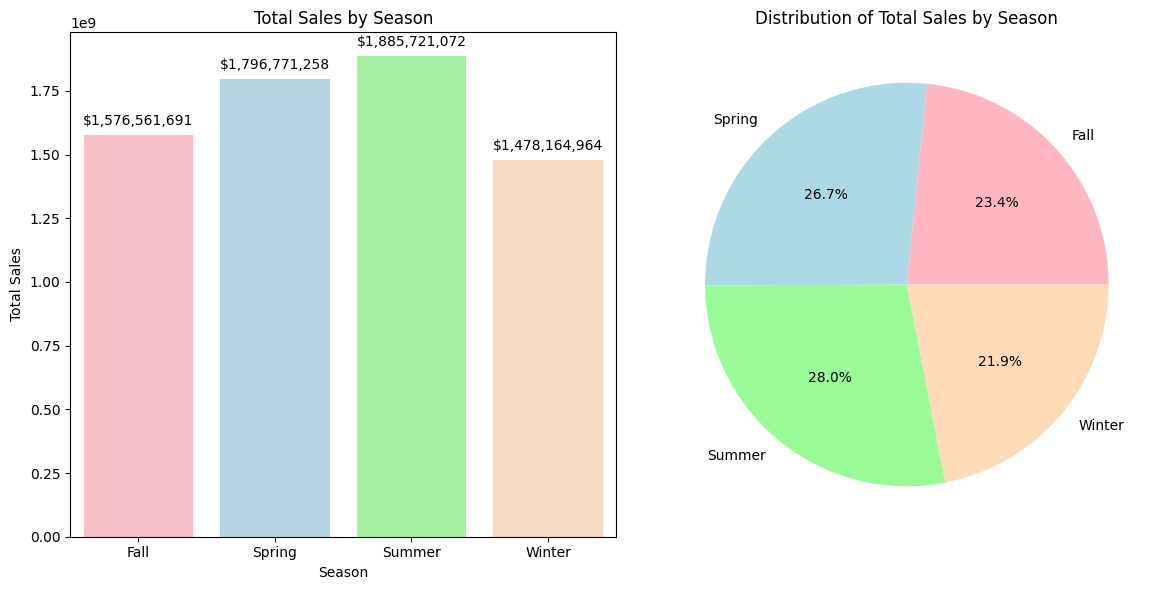

In [12]:
seasonCounts = data['Season'].value_counts()
seasonOrder = ['Winter', 'Spring', 'Summer', 'Autumn']

totalSalesBySeason = data.groupby('Season')['Weekly_Sales'].sum().sort_index()

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
ax = sns.barplot(x = totalSalesBySeason.index, y = totalSalesBySeason.values, palette = ['#FFB6C1', '#ADD8E6', '#98FB98', '#FFDAB9'])
for p in ax.patches:
    ax.annotate(f'${int(p.get_height()):,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.title('Total Sales by Season')

plt.subplot(1, 2, 2)
plt.pie(totalSalesBySeason, labels = totalSalesBySeason.index, autopct = '%1.1f%%', colors = ['#FFB6C1', '#ADD8E6', '#98FB98', '#FFDAB9'])
plt.title('Distribution of Total Sales by Season')

plt.tight_layout()
plt.show()

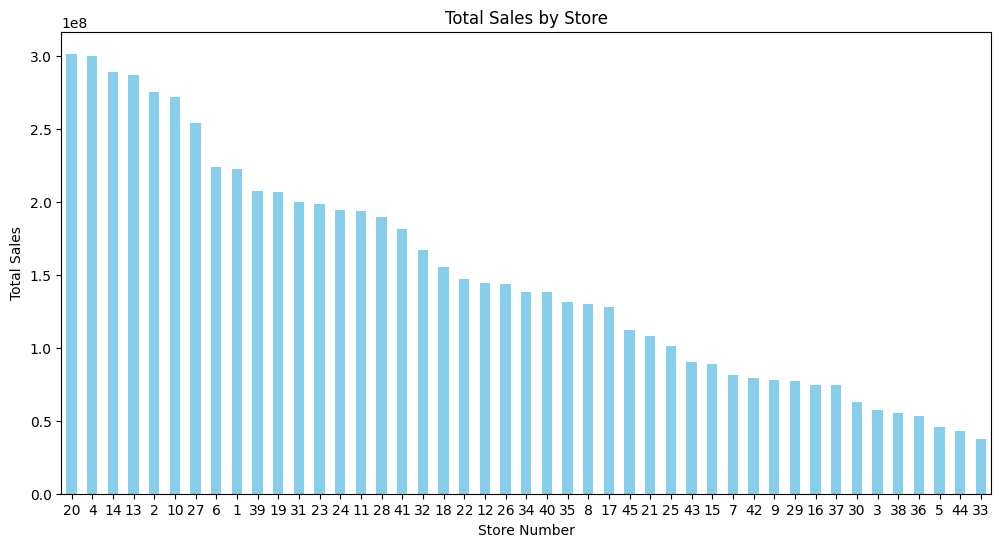

Highest Sales Store: 20, Total Sales: $301,397,792
Lowest Sales Store : 33, Total Sales: $37,160,222


In [13]:
totalSalesByStore = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)

plt.figure(figsize = (12, 6))
totalSalesByStore.plot(kind = 'bar', color = 'skyblue')

plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation = 0)
plt.show()

highestSalesStore = totalSalesByStore.idxmax()
highestSalesValue = totalSalesByStore.max()
print(f"Highest Sales Store: {highestSalesStore}, Total Sales: ${highestSalesValue:,.0f}")

lowestSalesStore = totalSalesByStore.idxmin()
lowestSalesValue = totalSalesByStore.min()
print(f"Lowest Sales Store : {lowestSalesStore}, Total Sales: ${lowestSalesValue:,.0f}")

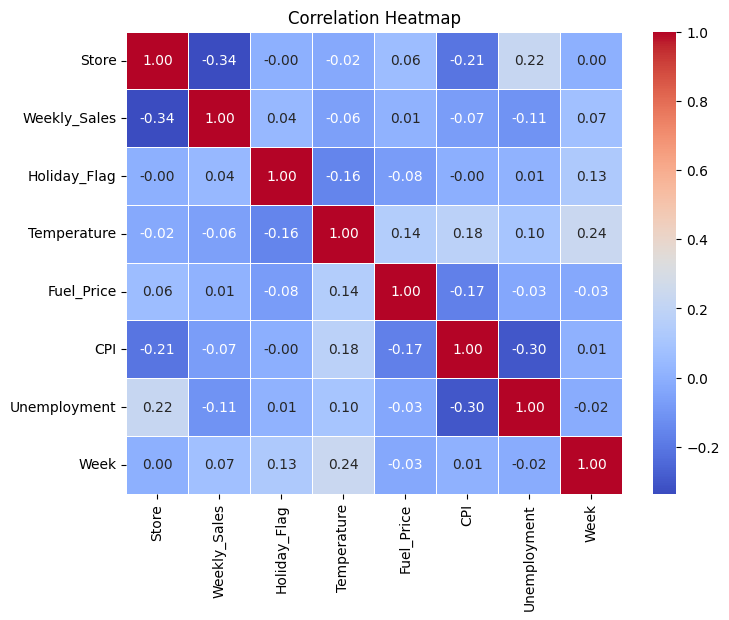

In [14]:
correlationMap = data.select_dtypes(include = ['number']).corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlationMap, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = .5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
#Data preprocessing
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Month_Name      0
Season          0
Week            0
dtype: int64

In [16]:
data.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Month_Name              object
Season                  object
Week                     int32
dtype: object

In [17]:
dataPreprocess = data.copy()
dataPreprocess.drop(['Date'], axis = 1, inplace = True)

dataPreprocess.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Month_Name       object
Season           object
Week              int32
dtype: object

In [18]:
dataPreprocess['Store'] = dataPreprocess['Store'].astype('object')
dataPreprocess['Holiday_Flag'] = dataPreprocess['Holiday_Flag'].astype('object')
dataPreprocess['Week'] = dataPreprocess['Week'].astype('object')

dataPreprocess.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Month_Name       object
Season           object
Week             object
dtype: object

In [19]:
X = dataPreprocess.drop('Weekly_Sales', axis = 1)
y = dataPreprocess['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

numericalFeatures = dataPreprocess.select_dtypes('number').columns.to_list()
numericalFeatures.remove('Weekly_Sales')

categoricalFeatures = dataPreprocess.select_dtypes('object').columns.to_list()

print(f"Numerical Features  : {numericalFeatures}")
print(f"Categorical Features: {categoricalFeatures}")

Numerical Features  : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical Features: ['Store', 'Holiday_Flag', 'Month_Name', 'Season', 'Week']


In [20]:
preprocessor = ColumnTransformer([('num_features', StandardScaler(), numericalFeatures),
                                  ('cat_features', BinaryEncoder(), categoricalFeatures),])

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [21]:
#Model Building and Evaluation
#Calculating the evaluation metrics of the decision tree
def evaluateModel(model, X, y_test):
    
    y_predict = model.predict(X)
    
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_predict)

    print(f"Mean Absolute Error    : {MAE}")
    print(f"Mean Squared Error     : {MSE}")
    print(f"Root Mean Squared Error: {RMSE}")
    print(f"\nR2 Score: {R2}")

In [22]:
#Comparing the predicted value to the actual value of training set 
def checkModel(model, X, y_actual):

    y_predicted = model.predict(X)

    plt.figure(figsize = (8, 4))

    sns.kdeplot(y_actual, label = 'Actual Values', color = 'blue', fill = False)
    sns.kdeplot(y_predicted, label = 'Predicted Values', color = 'orange', fill = False)

    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title('Distribution of Actual vs. Predicted Values')
    plt.legend()
    plt.show()


Evaluation for Decision Tree Regressor

Mean Absolute Error    : 0.0
Mean Squared Error     : 0.0
Root Mean Squared Error: 0.0

R2 Score: 1.0


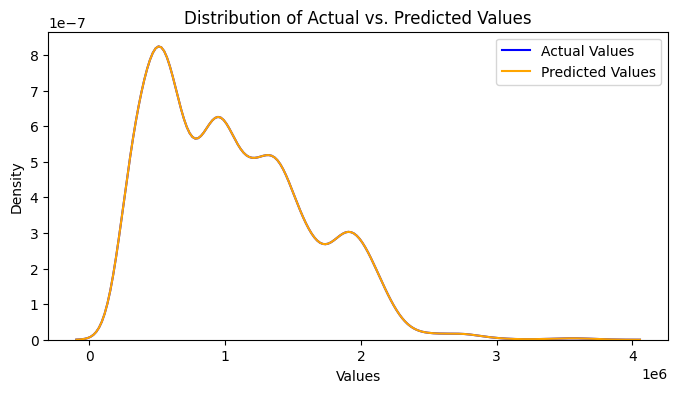

In [23]:
decisionTree_regressor = DecisionTreeRegressor()
decisionTree_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Decision Tree Regressor\n")
evaluateModel(decisionTree_regressor, X_train_transformed, y_train)

checkModel(decisionTree_regressor, X_train_transformed, y_train)


Evaluation for Random Forest Regressor

Mean Absolute Error    : 25987.259544114237
Mean Squared Error     : 2417995985.793723
Root Mean Squared Error: 49173.12259551678

R2 Score: 0.9923846776174817


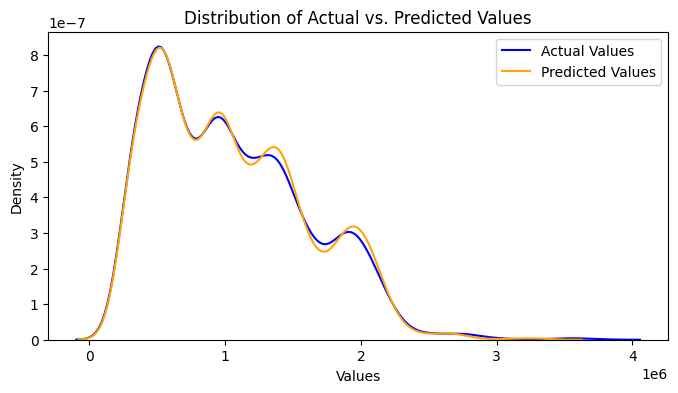

In [24]:
randomForest_regressor = RandomForestRegressor()
randomForest_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Random Forest Regressor\n")
evaluateModel(randomForest_regressor, X_train_transformed, y_train)

checkModel(randomForest_regressor, X_train_transformed, y_train)


Evaluation for XGB Regressor

Mean Absolute Error    : 28017.820711198525
Mean Squared Error     : 1583487170.899722
Root Mean Squared Error: 39793.054304736674

R2 Score: 0.9950129092993408


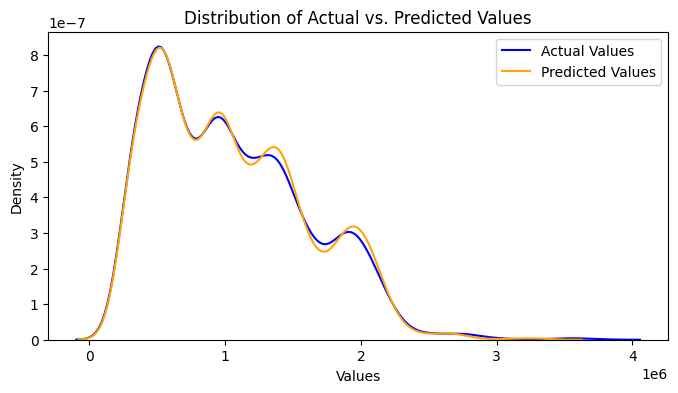

In [25]:
XGB_regressor = XGBRegressor()
XGB_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for XGB Regressor\n")
evaluateModel(XGB_regressor, X_train_transformed, y_train)

checkModel(randomForest_regressor, X_train_transformed, y_train)

In [26]:
#Tuning the model to optimise the performance
def tuneModel(model, X_train, y_train, param_grid, scoring = 'r2', cv=5):   
    
    grid_search = GridSearchCV(estimator = model,
                               param_grid = param_grid,
                               scoring = 'r2',
                               cv = cv)
    
    grid_search.fit(X_train, y_train)

    bestParamaters = grid_search.best_params_
    bestScore = grid_search.best_score_

    print(f"Best parameters: {bestParamaters} \n")
    print(f"Best R2 score  : {bestScore}")
    
    bestModel = grid_search.best_estimator_
    return bestModel


In [27]:
#Performing cross validation score for the model
def crossValidScore(model, X_train, y_train, scoring = 'r2', cv = 5):
    
    result = cross_val_score(model, X_train, y_train, scoring = scoring, cv = cv)

    print(f"\nCross Validation Scores ({scoring}): {result}")
    print(f"Mean Squared Error: {result.mean() * 100:.2f}%")
    print(f"Standard Deviation: {result.std()}")

In [28]:
dt_parameter = {'max_depth': np.arange(2, 15),
                'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

decisionTree_regressor_tuned = tuneModel(decisionTree_regressor, X_train_transformed, y_train, dt_parameter, 'r2', cv = 5)

Best parameters: {'max_depth': 14, 'min_samples_split': 40} 

Best R2 score  : 0.918628887462221



Evaluation for tuned Decision Tree Regressor

Mean Absolute Error    : 68246.12428752006
Mean Squared Error     : 16315998228.682177
Root Mean Squared Error: 127734.09188107213

R2 Score: 0.9486138160551059


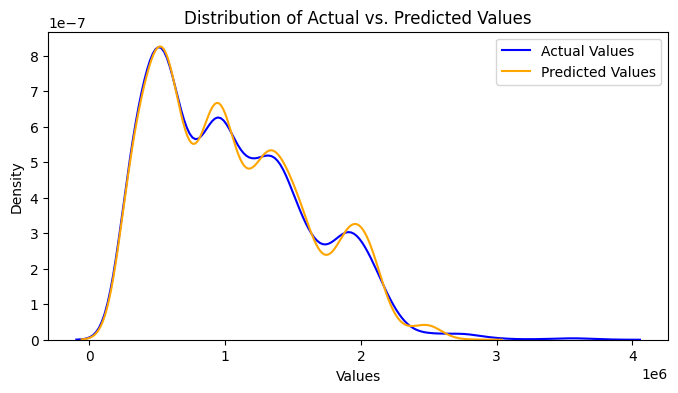


Cross Validation Scores (r2): [0.91614516 0.91929707 0.91659444 0.90698831 0.93479376]
Mean Squared Error: 91.88%
Standard Deviation: 0.009027398824515361


In [29]:
print("\nEvaluation for tuned Decision Tree Regressor\n")
evaluateModel(decisionTree_regressor_tuned, X_train_transformed, y_train)
checkModel(decisionTree_regressor_tuned, X_train_transformed, y_train)
crossValidScore(decisionTree_regressor_tuned, X_train_transformed, y_train, 'r2', 5)

In [30]:
rf_parameter = {'max_depth': np.arange(2,15),
                'n_estimators': np.arange(25,101,25)}

randomForest_regressor_tuned = tuneModel(randomForest_regressor, X_train_transformed, y_train, rf_parameter, 'r2', cv = 5)

Best parameters: {'max_depth': 13, 'n_estimators': 100} 

Best R2 score  : 0.9401853604792312



Evaluation for tuned Random Forest Regressor

Mean Absolute Error    : 30493.87935645467
Mean Squared Error     : 2825715079.2569695
Root Mean Squared Error: 53157.45553783561

R2 Score: 0.9911005926328611


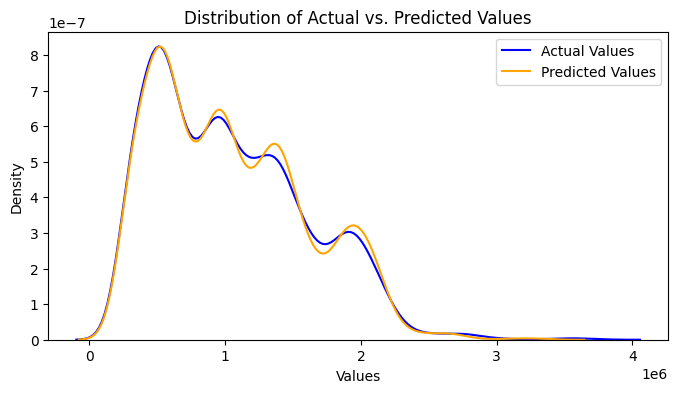


Cross Validation Scores (r2): [0.93416352 0.94389328 0.94004383 0.92858246 0.95556721]
Mean Squared Error: 94.05%
Standard Deviation: 0.009175071089825074


In [31]:
print("\nEvaluation for tuned Random Forest Regressor\n")
evaluateModel(randomForest_regressor_tuned, X_train_transformed, y_train)
checkModel(randomForest_regressor_tuned, X_train_transformed, y_train)
crossValidScore(randomForest_regressor_tuned, X_train_transformed, y_train, 'r2', 5)

In [32]:
xgb_parameter = {'max_depth': np.arange(2,15),
                 'n_estimators': np.arange(25,101,25)}

XGB_regressor_tuned = tuneModel(XGB_regressor, X_train_transformed, y_train, xgb_parameter, 'r2', cv = 5)

Best parameters: {'max_depth': 8, 'n_estimators': 100} 

Best R2 score  : 0.9672802879056694



Evaluation for tuned XGB Regressor

Mean Absolute Error    : 11046.52782488345
Mean Squared Error     : 254432961.64278126
Root Mean Squared Error: 15950.954881848962

R2 Score: 0.999198679799705


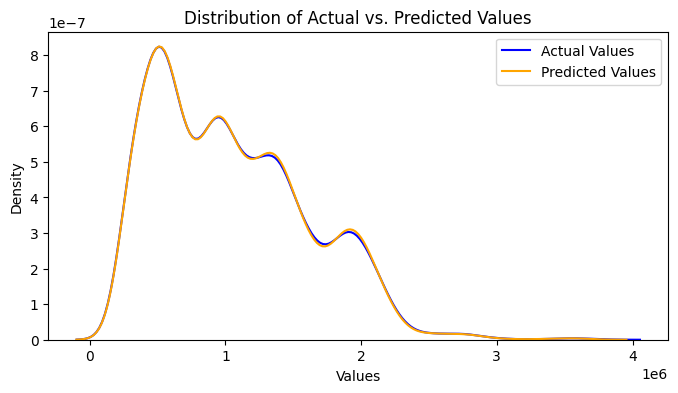


Cross Validation Scores (r2): [0.96818896 0.96875672 0.96937587 0.95935368 0.97072621]
Mean Squared Error: 96.73%
Standard Deviation: 0.00405222011539507


In [33]:
print("\nEvaluation for tuned XGB Regressor\n")
evaluateModel(XGB_regressor_tuned, X_train_transformed, y_train)
checkModel(XGB_regressor_tuned, X_train_transformed, y_train)
crossValidScore(XGB_regressor_tuned, X_train_transformed, y_train, 'r2', 5)

In [34]:
print("\nTesting the tuned Decision Tree Regressor\n")
evaluateModel(decisionTree_regressor_tuned, X_test_transformed, y_test)


Testing the tuned Decision Tree Regressor

Mean Absolute Error    : 83080.24868001975
Mean Squared Error     : 24089955356.867302
Root Mean Squared Error: 155209.39197376976

R2 Score: 0.9252223683862563


In [35]:
print("\nTesting the tuned Random Forest Regressor\n")
evaluateModel(randomForest_regressor, X_test_transformed, y_test)


Testing the tuned Random Forest Regressor

Mean Absolute Error    : 71628.41210233101
Mean Squared Error     : 17495307512.556824
Root Mean Squared Error: 132269.82842869655

R2 Score: 0.9456928150856787


In [36]:
print("\nTesting the tuned XGB Regressor\n")
evaluateModel(XGB_regressor_tuned, X_test_transformed, y_test)


Testing the tuned XGB Regressor

Mean Absolute Error    : 59918.92093531469
Mean Squared Error     : 9347367586.902597
Root Mean Squared Error: 96681.78518677961

R2 Score: 0.9709848358115618
